---
title: "Example with control"
---

In [1]:
# | include: false
import os

os.environ["USE_PYGEOS"] = "0"

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd

import ribasim

from pathlib import Path

Set up the nodes:

In [3]:
xy = np.array(
    [
        (0.0, 0.0), # 1: Basin
        (1.0, 1.0), # 2: Control
        (1.0, 0.0), # 3: Pump
        (1.0, -1.0), # 4: LinearResistance
        (2.0, 0.0) # 5: Basin
    ]
)
node_xy = gpd.points_from_xy(x=xy[:, 0], y=xy[:, 1])

node_type = [
    "Basin",
    "Control",
    "Pump",
    "LinearResistance",
    "Basin",
]

# Make sure the feature id starts at 1: explicitly give an index.
node = ribasim.Node(
    static=gpd.GeoDataFrame(
        data={"type": node_type},
        index=pd.Index(np.arange(len(xy)) + 1, name="fid"),
        geometry=node_xy,
        crs="EPSG:28992",
    )
)

Setup the edges:

In [4]:
from_id = np.array(
    [1,1,2,3,4], dtype=np.int64
)
to_id = np.array(
    [3,4,3,5,5], dtype=np.int64
)

edge_type = ["flow","flow","control","flow","flow"]

lines = ribasim.utils.geometry_from_connectivity(node, from_id, to_id)
edge = ribasim.Edge(
    static=gpd.GeoDataFrame(
        data={"from_node_id": from_id, "to_node_id": to_id,
              "edge_type": edge_type},
        geometry=lines,
        crs="EPSG:28992",
    )
)

Setup the basins:

In [5]:
profile = pd.DataFrame(
    data={
        "node_id": [1,1,5,5],
        "storage": [0.0, 100.0] * 2,
        "area": [100.0, 100.0] * 2,
        "level": [0.0, 1.0] * 2,
    }
)

static = pd.DataFrame(
    data={
        "node_id": [1,5],
        "drainage": [0.0] * 2,
        "potential_evaporation": [0.0] * 2,
        "infiltration": [0.0] * 2,
        "precipitation": [0.0] * 2,
        "urban_runoff": [0.0] * 2,
    }
)

state = pd.DataFrame(
    data={
        "node_id": [1,5],
        "storage": [100.0, 0.0]
    }
)

basin = ribasim.Basin(profile=profile, static=static, state=state)

Setup the control:

In [12]:
condition = pd.DataFrame(
    data={
        "node_id": [2,2],
        "listen_node_id": [5,1],
        "variable": ["level","level"],
        "greater_than": [0.4,0.8],
    }
)

# False, False -> "Off" 
# True,  False -> "On"
# False, True  -> "Off" 
# True,  True  -> "On"

# Truth state as subset of the conditions above and in that order

logic = pd.DataFrame(
    data={
        "node_id":[2,2,2,2],
        "truth_state":["FF", "TF", "FT", "TT"],
        "control_state":["off","on", "off", "on"],
    }
)

control = ribasim.Control(condition = condition, logic=logic)

Setup the pump:

In [7]:
pump = ribasim.Pump(
    static=pd.DataFrame(
        data={
            "node_id": [3],
            "flow_rate": [0],
        }
    ),
    control=pd.DataFrame(
        data={
            "node_id": [3,3],
            "control_state": ["On", "Off"],
            "flow_rate": [1e-3,0.0]
        }
    )
)

Setup the linear resistance:

In [8]:
linear_resistance = ribasim.LinearResistance(
    static=pd.DataFrame(
        data={
            "node_id": [4],
            "resistance": [1e5],
        }
    )
)

Setup a model:

In [9]:
model = ribasim.Model(
    modelname="control",
    node=node,
    edge=edge,
    basin=basin,
    linear_resistance=linear_resistance,
    pump=pump,
    control=control,
    starttime="2020-01-01 00:00:00",
    endtime="2021-01-01 00:00:00",
)

<Axes: >

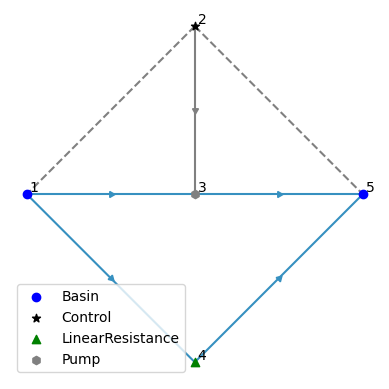

In [10]:
model.plot()

In [11]:
datadir = Path("data")
model.write(datadir / "control")

In [12]:
# | include: false
from subprocess import run

run(
    [
        "julia",
        "--project=../../core",
        "--eval",
        f'using Ribasim; Ribasim.run("{datadir.as_posix()}/control/control.toml")',
    ],
    check=True,
)

CompletedProcess(args=['julia', '--project=../../core', '--eval', 'using Ribasim; Ribasim.run("data/control/control.toml")'], returncode=0)

<Axes: xlabel='time'>

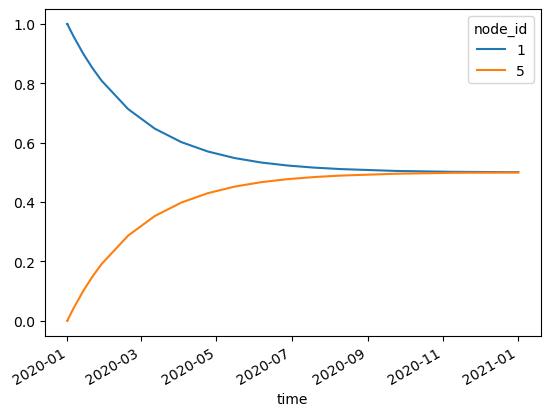

In [13]:
df_basin = pd.read_feather(datadir / "control/output/basin.arrow")
df_basin_wide = df_basin.pivot_table(
    index="time", columns="node_id", values=["storage", "level"]
)
df_basin_wide["level"].plot()

In [24]:
edges = set()

In [25]:
condition = model.control.condition

In [26]:
for node_id in condition.node_id.unique():
    for listen_node_id in condition.loc[condition.node_id==node_id,"listen_node_id"]:
        edges.add((node_id-1, listen_node_id-1))

In [27]:
start, end = list(zip(*edges))

In [28]:
x_start = model.node.static.iloc[list(start)].geometry.x

In [29]:
end

(0, 4)

In [30]:
x_end = model.node.static.iloc[list(end)].geometry.x